In [1]:
import tensorflow as tf
import cv2


E:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import numpy as np

In [3]:
# Read image

In [4]:
stop_img = cv2.imread("Stop.png")
Go_img = cv2.imread("Go.png")

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

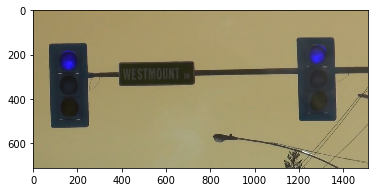

In [6]:
plt.imshow(stop_img)

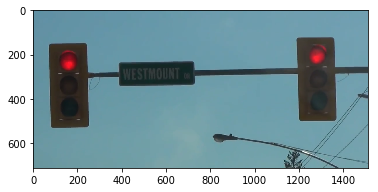

In [7]:
plt.imshow(cv2.cvtColor(stop_img, cv2.COLOR_BGR2RGB))

# Load Model

In [8]:
from utils import label_map_util
PATH_TO_CKPT = 'ssdlite_mobilenet_v2_coco_2018_05_09/frozen_inference_graph.pb'
PATH_TO_LABELS = 'mscoco_label_map.pbtxt'
NUM_CLASSES = 90

# load graph
detection_graph = tf.Graph()
with detection_graph.as_default():
	od_graph_def = tf.GraphDef()
	with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
		serialized_graph = fid.read()
		od_graph_def.ParseFromString(serialized_graph)
		tf.import_graph_def(od_graph_def, name='')
        
# load label
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map,max_num_classes=NUM_CLASSES,use_display_name=True)
category_index = label_map_util.create_category_index(categories)

# Make Prediction

In [9]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')  
        image_np_expanded = np.expand_dims(stop_img, axis=0)
        (boxes, scores, classes, num) = sess.run(
            [detection_boxes, detection_scores, detection_classes, num_detections],
            feed_dict={image_tensor: image_np_expanded})

In [15]:
im_width=stop_img.shape[1]
im_height = stop_img.shape[0]
ymin, xmin, ymax, xmax = boxes[0][0].tolist()


In [17]:
left, right, top, bottom = map(lambda x:int(x),[xmin * im_width, xmax * im_width,ymin * im_height, ymax * im_height])

In [41]:

new_img = cv2.rectangle(stop_img.copy(), (left, top), (right, bottom), (0, 128, 255), 2)

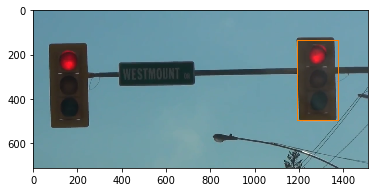

In [42]:
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

497

In [39]:
def traffic_signal_detection(frame,top,bottom,left,right,num=3,threshold=0.1):
    # if both red/green fail to pass the threshold, that means no traffic light is on, return None
    # if it has both red and green signal, something is wrong, return stop
#     ff = frame[top:bottom,left:right,:]
    height = bottom - top
    step_size = int(height/num)
    red_signal_part = frame[top:top+step_size,left:right,:]
    green_signal_part = frame[bottom-step_size:bottom,left:right,:]    
    green_flag = detect_green(green_signal_part)
    red_flag = detect_red(red_signal_part)
#     print (red_flag)
    if red_flag > threshold and red_flag > green_flag:
        return False
    if green_flag > threshold and green_flag > red_flag:
        return True
    return None
def detect_red(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    
    # lower mask (0-10)
    lower_red = np.array([0,70,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,70,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    
    mask = mask0+mask1
    rate = np.count_nonzero(mask) / (mask.shape[0] * mask.shape[1])
    return rate

def detect_green(frame):
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    lower = np.array([34,60,60], dtype=np.uint8)
    upper = np.array([84, 255, 255], dtype=np.uint8)
    mask = cv2.inRange(hsv, lower, upper)
    rate = np.count_nonzero(mask) / (mask.shape[0] * mask.shape[1])
    return rate


In [40]:
go_flag = traffic_signal_detection(cv2.cvtColor(stop_img, cv2.COLOR_BGR2RGB),top,bottom,left,right,num=3,threshold=0.0)

In [43]:
go_flag

False

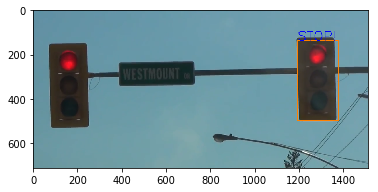

In [44]:
new_img = cv2.rectangle(stop_img.copy(), (left, top), (right, bottom), (0, 128, 255), 2)
font = cv2.FONT_HERSHEY_SIMPLEX
new_img = cv2.putText(new_img,'STOP!',(left, top), font, 2,(255,0,0),2,cv2.LINE_AA)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))